In [1]:
#!pip install -U featuretools
#!python -m pip install graphviz

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import featuretools as ft
import warnings
import matplotlib.pyplot as plt

from woodwork.logical_types import Categorical, PostalCode
from pandas.plotting import table

# Ignoring warnings for cleaner output
warnings.filterwarnings('ignore')

# Data Set

Source: https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-tutorial

Tables:
* clients: information about clients at a credit union
* loans: previous loans taken out by the clients
* payments: payments made/missed on the previous loans


In [3]:
# Load Data
clients = pd.read_csv('./data/clients.csv', parse_dates = ['joined'])
clients['joined'] = pd.to_datetime(clients['joined']).dt.date

loans = pd.read_csv('./data/loans.csv', parse_dates = ['loan_start', 'loan_end'])
loans['loan_start'] = pd.to_datetime(loans['loan_start']).dt.date
loans['loan_end'] = pd.to_datetime(loans['loan_end']).dt.date

payments = pd.read_csv('./data/payments.csv', parse_dates = ['payment_date'])
payments['payment_date'] = pd.to_datetime(payments['payment_date']).dt.date


# Adding an index as a new column 'payment_id'
payments['payment_id'] = payments.index

# Reordering columns with 'payment_id' as the first column
cols = payments.columns.tolist()
cols = cols[-1:] + cols[:-1]
payments = payments[cols]


# Extracting relevant columns for 'payments_due'
payments_due = payments[['payment_id', 'loan_id', 'payment_date','payment_amount']]
payments_due.columns = ['payment_id', 'loan_id', 'due_date', 'amount_due']
payments_due


# Extracting information for 'outcome' where payments were not missed
outcome = payments[payments['missed'] == 0][['payment_id','payment_date']]
outcome.columns = ['payment_id', 'outcome_time']

# Adjusting 'outcome_time' to avoid leakage by subtracting 1 day
outcome['outcome_time'] = outcome['outcome_time'] + pd.Timedelta(days=1)

# Resetting index for 'outcome'
outcome.reset_index(drop=True, inplace=True)
outcome['order_id'] = outcome.index

# Reordering columns in 'outcome'
cols = outcome.columns.tolist()
cols = cols[-1:] + cols[:-1]
outcome = outcome[cols]

In [4]:
# Sample data to visualize and understand the data

customer_id = 26326
loans_of_interest = [11251,11988]
#loans_of_interest = loans[(loans['client_id'] == customer_id)]['loan_id']

# Filter data for the specified customer and loans
clients_subset = clients[clients['client_id'] == customer_id]
loans_subset = loans[(loans['loan_id'].isin(loans_of_interest))].sort_values(by = 'loan_start')
payments_due_subset = payments_due[payments_due['loan_id'].isin(loans_of_interest)]
outcome_subset = outcome[outcome['payment_id'].isin(payments_due_subset['payment_id'])]

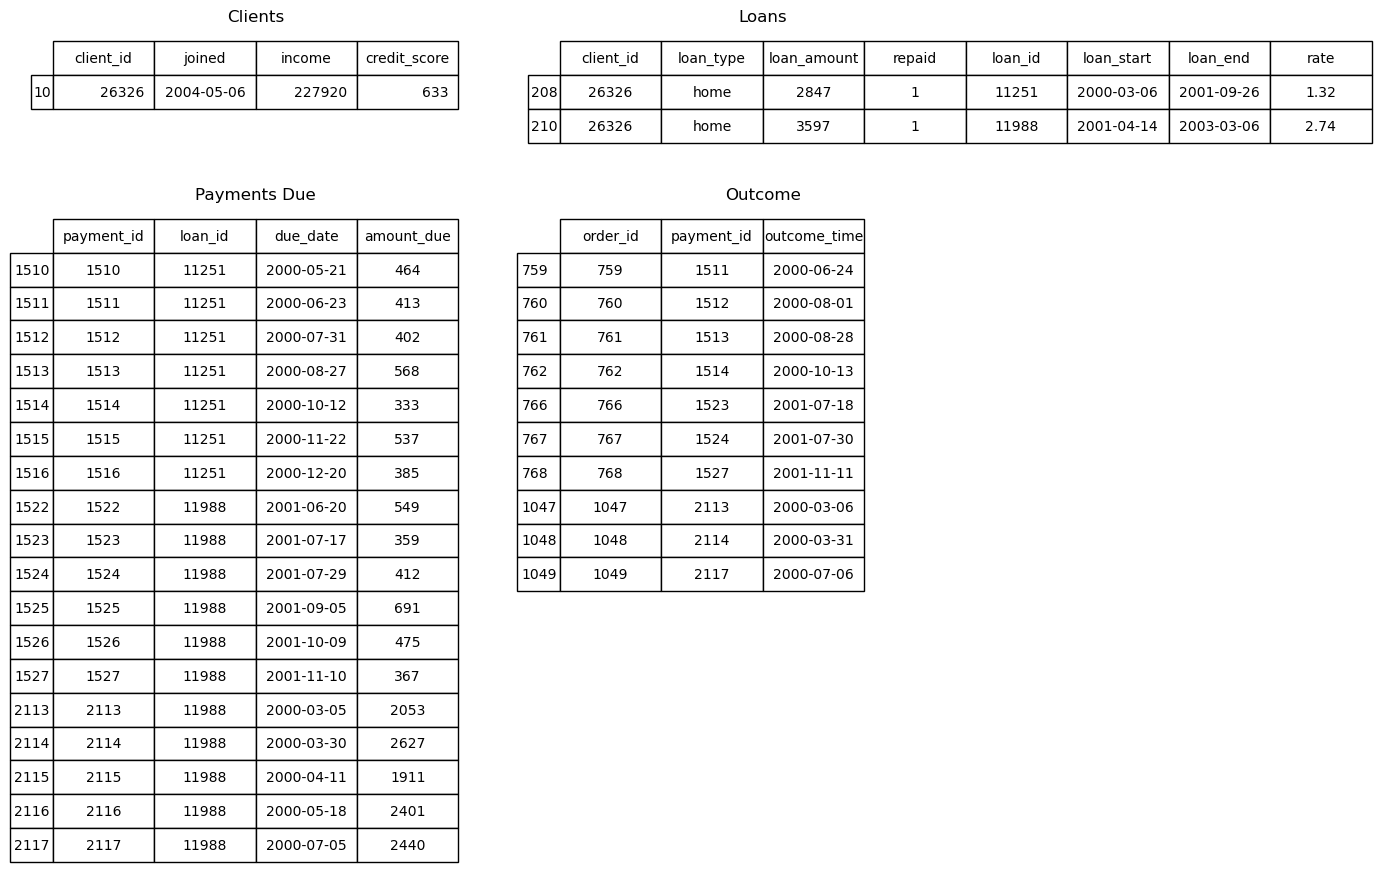

In [5]:
# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Hide the axes
for ax in axes.flatten():
    ax.axis('off')

# Plot Clients Subset
table_clients = table(axes[0, 0], clients_subset, loc='upper left', colWidths=[0.2]*len(clients_subset.columns))
table_clients.auto_set_font_size(False)
table_clients.set_fontsize(10)
table_clients.scale(1.2, 1.2)
axes[0, 0].set_title('Clients')

# Plot Loans Subset
table_loans = table(axes[0, 1], loans_subset, loc='upper left', colWidths=[0.2]*len(loans_subset.columns), cellLoc='center')
table_loans.auto_set_font_size(False)
table_loans.set_fontsize(10)
table_loans.scale(1.2, 1.2)
axes[0, 1].set_title('Loans')

# Plot Payments Due Subset
table_payments_due = table(axes[1, 0], payments_due_subset, loc='upper left', colWidths=[0.2]*len(payments_due_subset.columns), cellLoc='center')
table_payments_due.auto_set_font_size(False)
table_payments_due.set_fontsize(10)
table_payments_due.scale(1.2, 1.2)
axes[1, 0].set_title('Payments Due')

# Plot Outcome Subset
table_outcome = table(axes[1, 1], outcome_subset, loc='upper left', colWidths=[0.2]*len(outcome_subset.columns), cellLoc='center')
table_outcome.auto_set_font_size(False)
table_outcome.set_fontsize(10)
table_outcome.scale(1.2, 1.2)
axes[1, 1].set_title('Outcome')

# Adjust layout with reduced vertical space between top and bottom tables
plt.subplots_adjust(hspace=-0.7)

# Show the plot
plt.show()


## Data Representation with EntitySets
An EntitySet is a collection of dataframes and the relationships between them. They are useful for preparing raw, structured datasets for feature engineering. While many functions in Featuretools take dataframes and relationships as separate arguments, it is recommended to create an EntitySet, so you can more easily manipulate your data as needed.

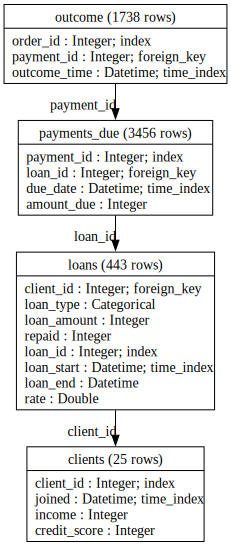

In [7]:
es = ft.EntitySet(id = 'clients')

## Entities Dataframe
# Adding 'clients' dataframe to the EntitySet with 'client_id' as the index and 'joined' as the time index
es = es.add_dataframe(
    dataframe_name="clients",
    dataframe=clients,
    index="client_id",
    time_index="joined")

# Adding 'loans' dataframe to the EntitySet with 'loan_id' as the index and 'loan_start' as the time index
es = es.add_dataframe(
    dataframe_name="loans",
    dataframe=loans,
    index="loan_id",
    time_index="loan_start")

# Adding 'payments_due' dataframe to the EntitySet with 'payment_id' as the index and 'due_date' as the time index
es = es.add_dataframe(
    dataframe_name="payments_due",
    dataframe=payments_due,
    index="payment_id",
    time_index="due_date")

# Adding 'outcome' dataframe to the EntitySet with 'payment_id' as the index and 'outcome_time' as the time index
es = es.add_dataframe(
    dataframe_name="outcome",
    dataframe=outcome,
    time_index="outcome_time")


## Adding Relationships in Dataframes
# Establishing relationships between 'clients' and 'loans', 'loans' and 'payments_due', 'payments_due' and 'outcome'

# Relationship between clients and previous loans
ed = es.add_relationship('clients', 'client_id', 'loans', 'client_id')

# Relationship between previous loans and payments
es = es.add_relationship('loans', 'loan_id', 'payments_due', 'loan_id')

# Relationship between payments and outcome
es = es.add_relationship('payments_due', 'payment_id', 'outcome', 'payment_id')

es.plot()

# Feature primitives
Feature primitives are the building blocks of Featuretools. They define individual computations that can be applied to raw datasets to create new features. Because a primitive only constrains the input and output data types, they can be applied across datasets and can stack to create new calculations.

Feature primitives fall into two categories:

1. Aggregation: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
2. Transformation: an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.

In [8]:
# Listing available primitives
primitives = ft.list_primitives()

In [9]:
# Displaying a subset of Aggregation primitives
primitives[primitives['type'] == 'aggregation'].head(5)

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,date_first_event,aggregation,False,False,Determines the first datetime from a list of d...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = Datetime)>
1,max_consecutive_positives,aggregation,False,False,Determines the maximum number of consecutive p...,"<ColumnSchema (Logical Type = Integer)>, <Colu...",<ColumnSchema (Logical Type = Integer) (Semant...
2,num_consecutive_greater_mean,aggregation,False,False,Determines the length of the longest subsequen...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = IntegerNullable)...
3,variance,aggregation,False,False,Calculates the variance of a list of numbers.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semanti...
4,count_outside_range,aggregation,False,False,Determines the number of values that fall outs...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = IntegerNullable)...


In [10]:
# Displaying a subset of Transformation primitives
primitives[primitives['type'] == 'transform'].head(5)

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
65,or,transform,True,True,Performs element-wise logical OR of two lists.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = BooleanNullable)>
66,cum_min,transform,False,False,Calculates the cumulative minimum.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
67,expanding_min,transform,False,False,Computes the expanding minimum of events over ...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Semantic Tags = ['numeric'])>
68,multiply_numeric_scalar,transform,True,True,Multiplies each element in the list by a scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
69,divide_numeric_scalar,transform,True,True,Divides each element in the list by a scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>


# Creating Features for each session and cutoff time considersation

Cutoff time is crucial in feature engineering to prevent leakage. It is the point in time where the data is considered and beyond which future data is ignored.

In our case, the cutoff time is derived from the 'due_date' column in 'payments_due'.


In [11]:
# Extracting 'payment_id' and 'due_date' for cutoff time
cutoff_times = es['payments_due'][['payment_id', 'due_date']].sort_values(by='due_date')

# Rename columns
cutoff_times.rename(columns = {'due_date': 'time'},
                    inplace = True)
cutoff_times.head()

cutoff_times['time'] = cutoff_times['time'] - pd.Timedelta(0, 'days')
payments_due.head(5)

,payment_id,loan_id,due_date,amount_due
2113,2113,11988,2000-03-05,2053
726,726,11140,2000-03-19,402
2114,2114,11988,2000-03-30,2627
3223,3223,11430,2000-04-05,1284
2115,2115,11988,2000-04-11,1911


In [12]:
## Create feature per payment entry

# Defining aggregation and transformation primitives for deep feature synthesis
agg_primitives =  ["sum","count","max"]
trans_primitives = ["time_since_previous"]

# Performing deep feature synthesis using Featuretools
f, feature_names = ft.dfs(entityset=es, target_dataframe_name='payments_due',
                       agg_primitives = agg_primitives,
                       trans_primitives = trans_primitives,
                       n_jobs = -1, verbose = 1,
                       cutoff_time = cutoff_times,                    
                       cutoff_time_in_index = True,
                       max_depth = 2)
feature_names

Built 18 features
Elapsed: 00:00 | Progress:   0%|          

EntitySet scattered to 8 workers in 15 seconds
Elapsed: 02:08 | Progress: 100%|██████████


[<Feature: loan_id>,
 <Feature: amount_due>,
 <Feature: COUNT(outcome)>,
 <Feature: TIME_SINCE_PREVIOUS(due_date)>,
 <Feature: loans.client_id>,
 <Feature: loans.loan_type>,
 <Feature: loans.loan_amount>,
 <Feature: loans.repaid>,
 <Feature: loans.rate>,
 <Feature: MAX(outcome.TIME_SINCE_PREVIOUS(outcome_time))>,
 <Feature: SUM(outcome.TIME_SINCE_PREVIOUS(outcome_time))>,
 <Feature: loans.COUNT(payments_due)>,
 <Feature: loans.MAX(payments_due.amount_due)>,
 <Feature: loans.SUM(payments_due.amount_due)>,
 <Feature: loans.COUNT(outcome)>,
 <Feature: loans.TIME_SINCE_PREVIOUS(loan_start)>,
 <Feature: loans.clients.income>,
 <Feature: loans.clients.credit_score>]

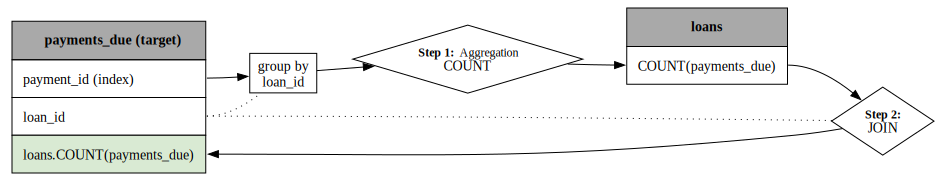

In [40]:
# Visualize the feature
graph_feature = ft.graph_feature(feature_names[11])
graph_feature

In [15]:
f.reset_index(inplace = True)

In [19]:
f[f.payment_id == 1512].head(10)

,payment_id,time,loan_id,amount_due,COUNT(outcome),TIME_SINCE_PREVIOUS(due_date),loans.client_id,loans.loan_type,loans.loan_amount,loans.repaid,loans.rate,MAX(outcome.TIME_SINCE_PREVIOUS(outcome_time)),SUM(outcome.TIME_SINCE_PREVIOUS(outcome_time)),loans.COUNT(payments_due),loans.MAX(payments_due.amount_due),loans.SUM(payments_due.amount_due),loans.COUNT(outcome),loans.TIME_SINCE_PREVIOUS(loan_start),loans.clients.income,loans.clients.credit_score
27,1512,2000-07-31,11251,402,0,NaN,26326,home,2847,1,1.32,NaN,0.0,3,464.0,1279.0,1,NaN,<NA>,<NA>


In [43]:
# Vaidating the features generated and the time cuttoff
print(payments_due[payments_due['payment_id'] == 1512])
print('\n')

# Count(outcome)
print('Count(outcome)')
print(outcome[((outcome['payment_id'] == 1512) & (outcome['outcome_time'] <= '2000-07-31'))])
print('\n')


# loans
print('loans')
print(loans[loans['loan_id'] == 11251])
print('\n')
# loans.COUNT(payments_due)	
print('loans.COUNT(payments_due)')
print(payments_due[((payments_due['loan_id'] == 11251) & (payments_due['due_date'] <= '2000-07-31'))])

      payment_id  loan_id   due_date  amount_due
1512        1512    11251 2000-07-31         402


Count(outcome)
Empty DataFrame
Columns: [order_id, payment_id, outcome_time]
Index: []


loans
       client_id loan_type  loan_amount  repaid  loan_id loan_start  \
11251      26326      home         2847       1    11251 2000-03-06   

        loan_end  rate  
11251 2001-09-26  1.32  


loans.COUNT(payments_due)
      payment_id  loan_id   due_date  amount_due
1510        1510    11251 2000-05-21         464
1511        1511    11251 2000-06-23         413
1512        1512    11251 2000-07-31         402
